# 1.Prepare Data

## 1.1 Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from catboost import cv, Pool, CatBoostClassifier

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Read training data from CSV
train_data_path = '/kaggle/input/playground-series-s4e2/train.csv'
df = pd.read_csv(train_data_path)

# Read test data from CSV
test_data_path = '/kaggle/input/playground-series-s4e2/test.csv'
test = pd.read_csv(test_data_path)

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


## 1.2 Explore

In [3]:
# Display information about the training data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

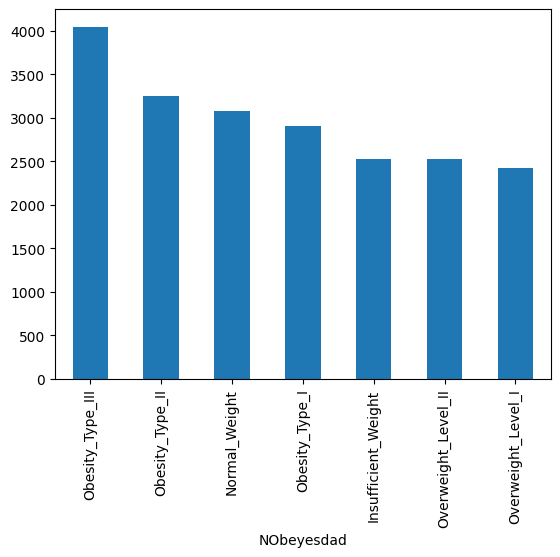

In [4]:
# Target Distrpution
df['NObeyesdad'].value_counts().plot(kind='bar');

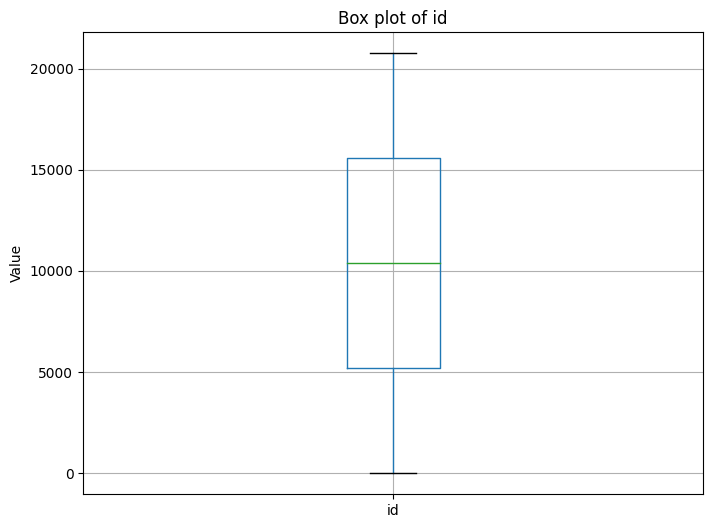

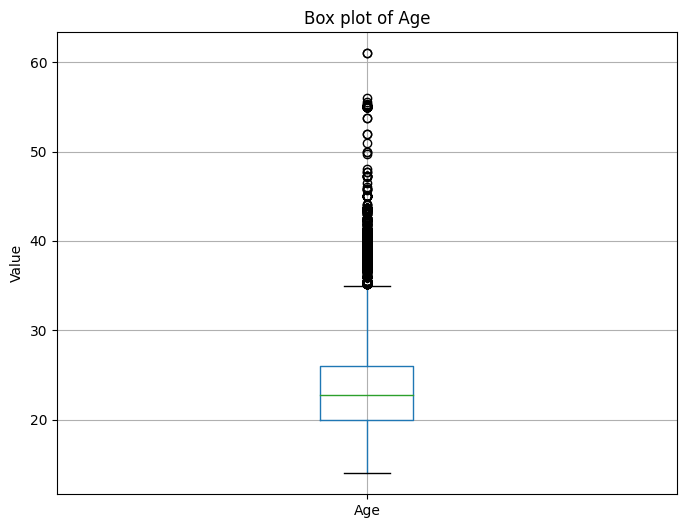

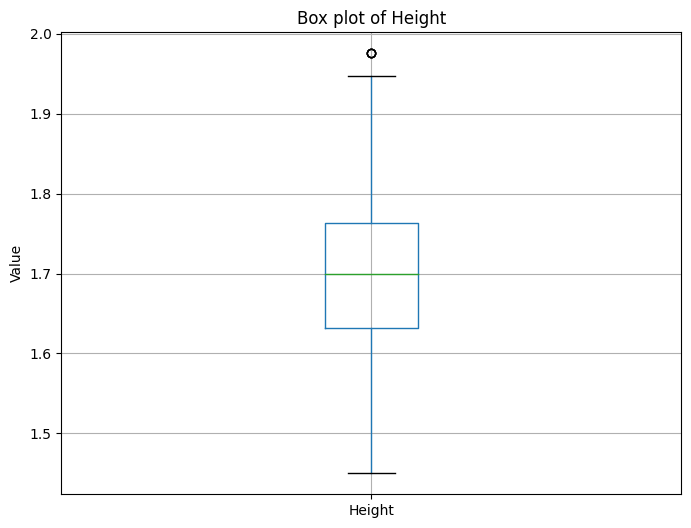

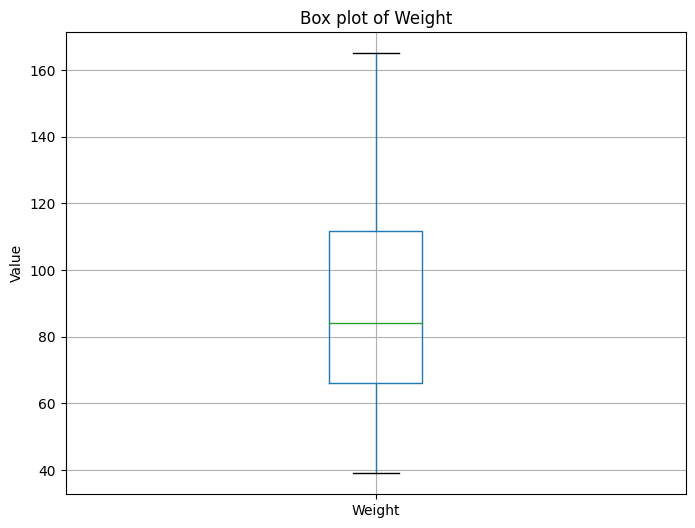

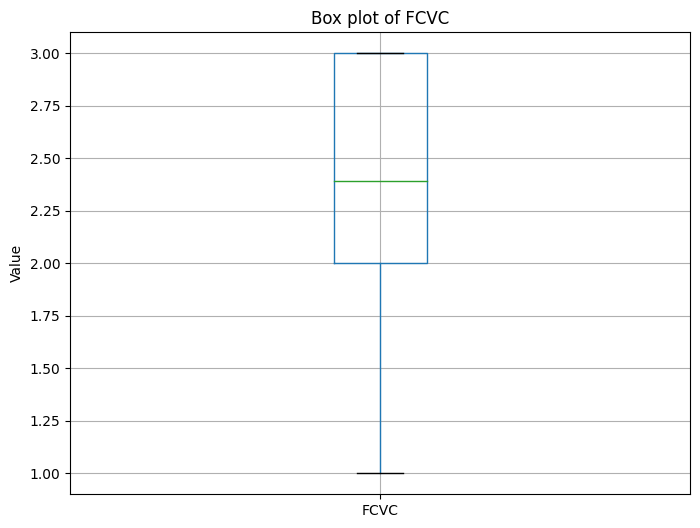

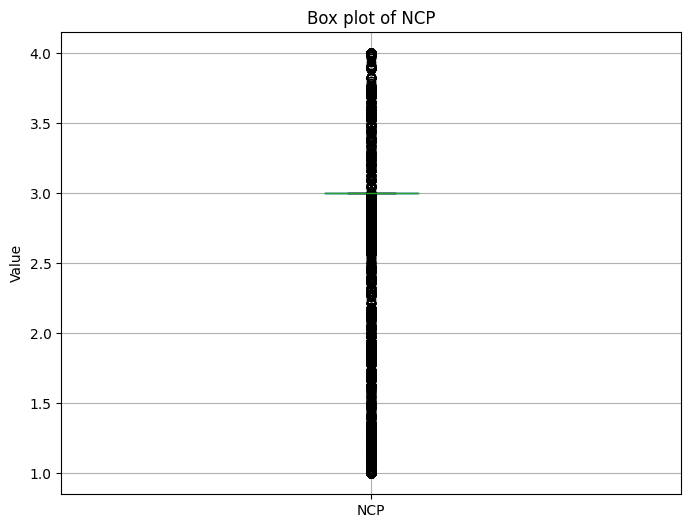

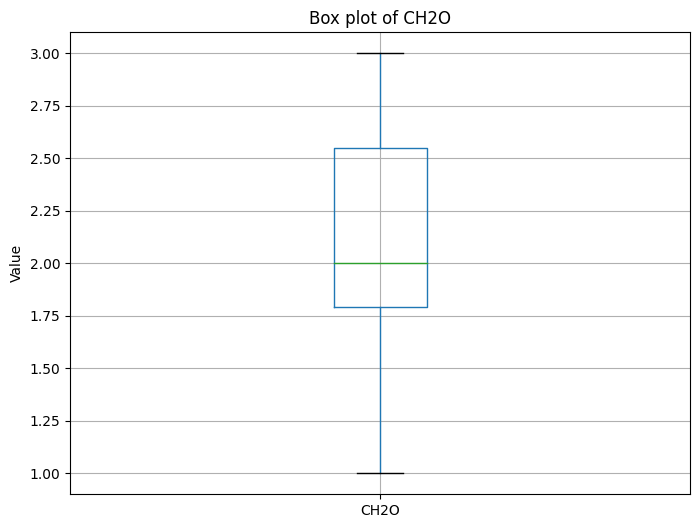

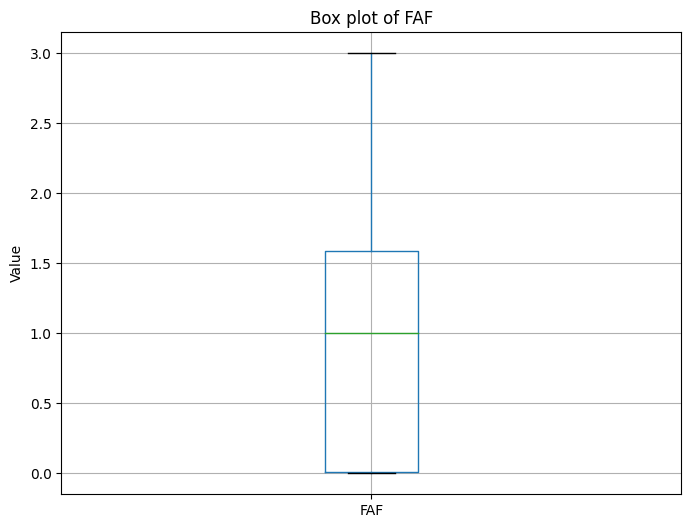

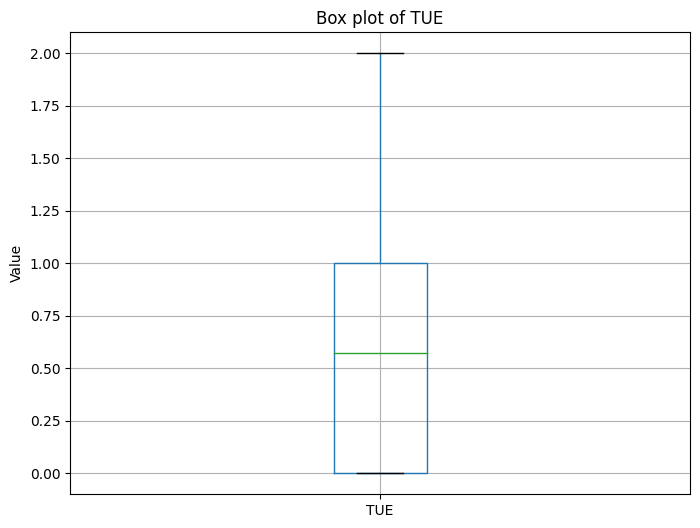

In [5]:
# Create box plots for numerical columns
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 6))
    df.boxplot(column=col)
    plt.title(f'Box plot of {col}')
    plt.ylabel('Value')
    plt.show()


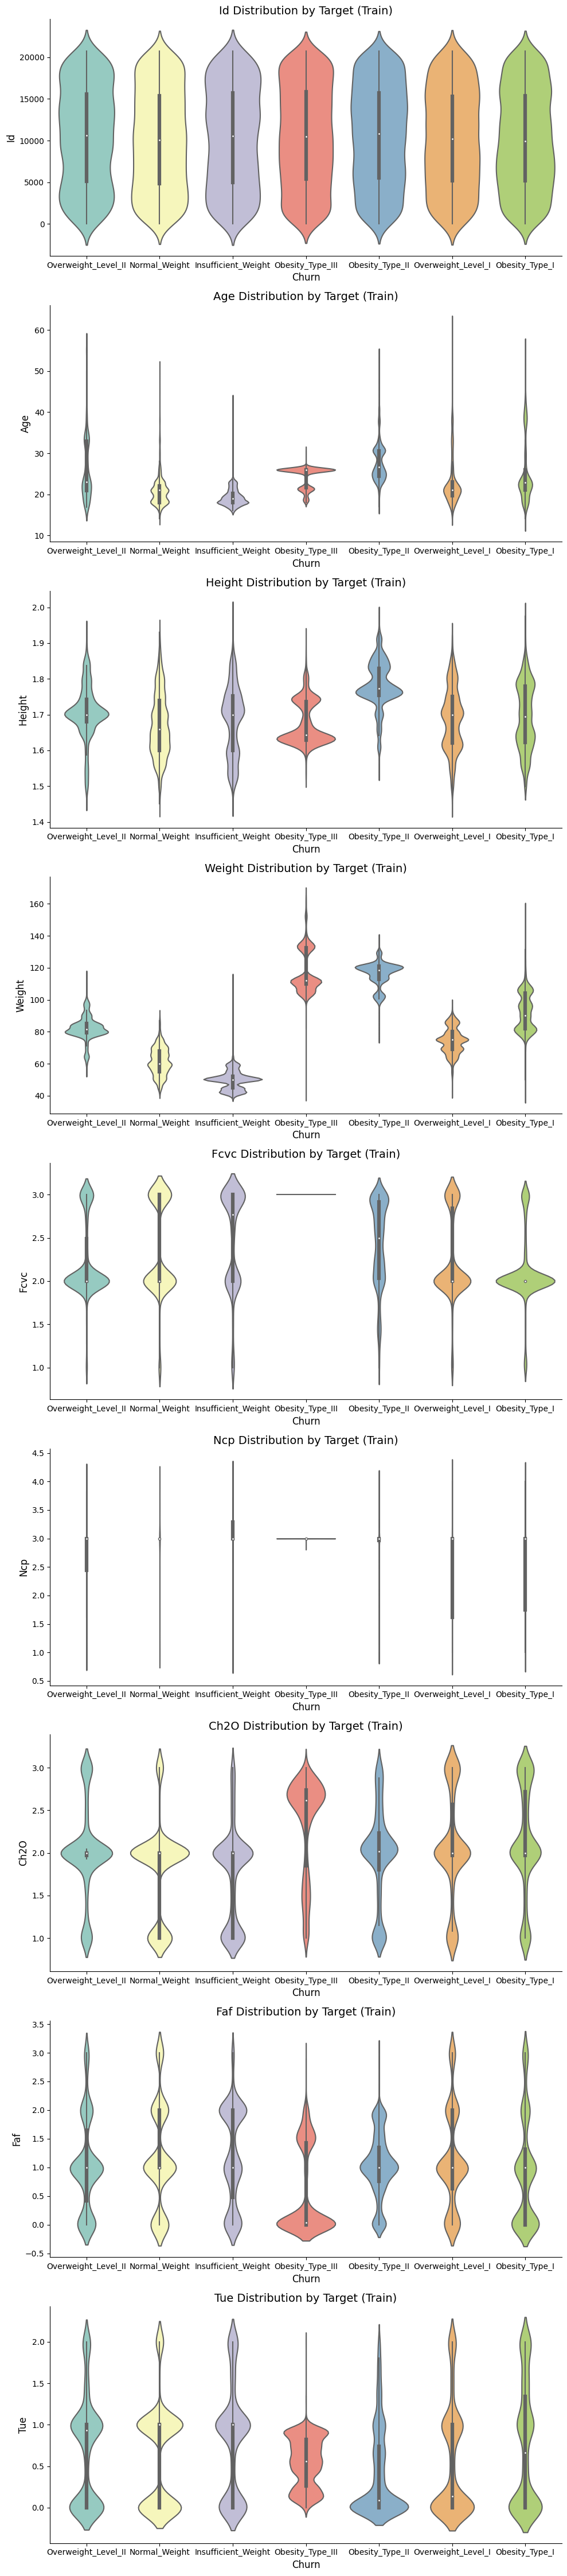

In [6]:
cont_cols = [f for f in df.columns if df[f].dtype != 'O' and df[f].nunique() > 21]

# Calculate the number of rows for subplots
n_rows = len(cont_cols)

# Create subplots for violin plots
fig, axs = plt.subplots(n_rows, 1, figsize=(10, 5 * n_rows))
sns.set_palette("Set3")

# Iterate through each continuous column and create a violin plot
for i, col in enumerate(cont_cols):
    sns.violinplot(x='NObeyesdad', y=col, data=df, ax=axs[i])
    axs[i].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i].set_xlabel('Churn', fontsize=12)
    axs[i].set_ylabel(col.title(), fontsize=12)
    sns.despine()

# Adjust layout for better visualization
fig.tight_layout()

# Show the plots
plt.show()

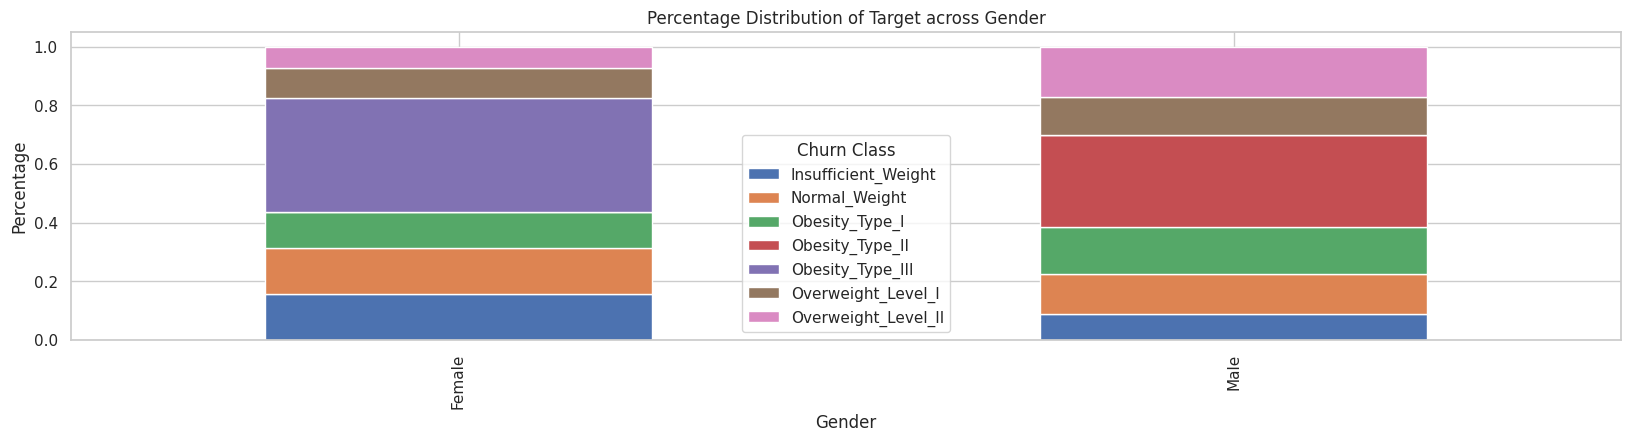

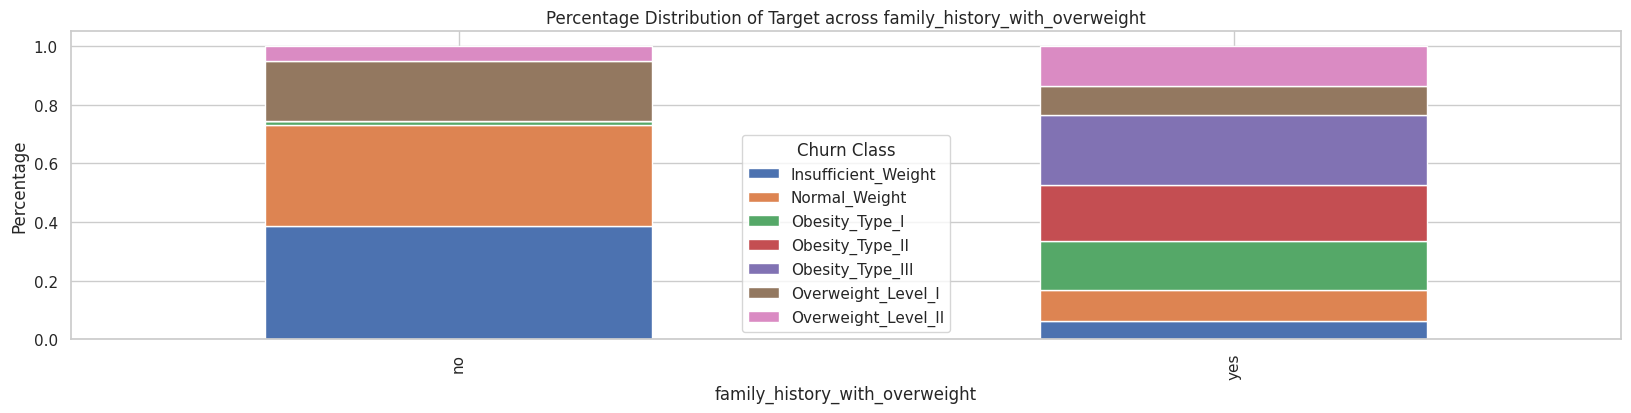

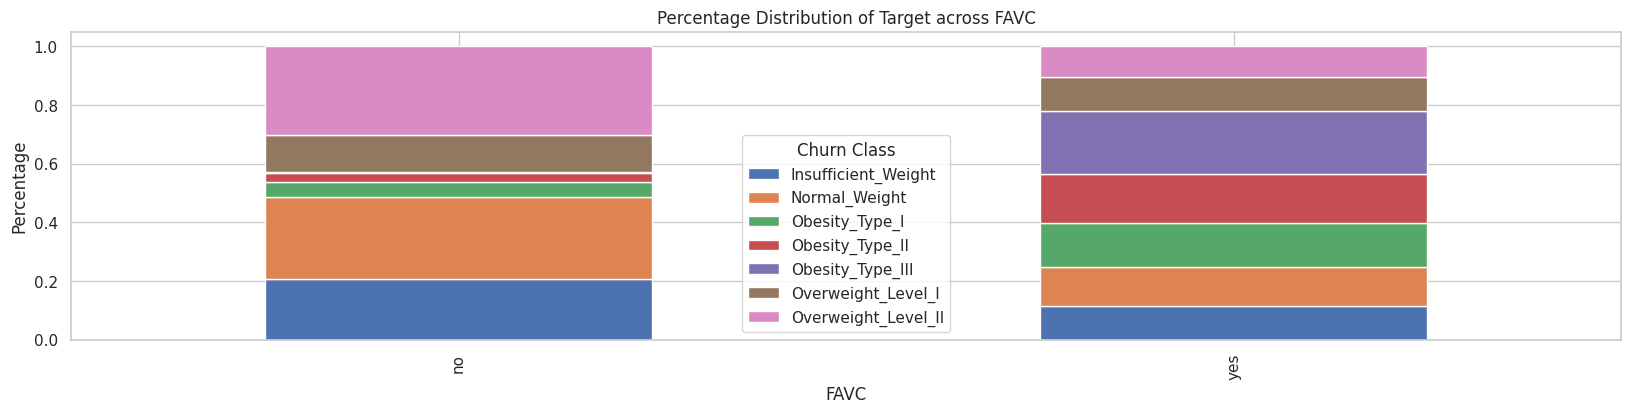

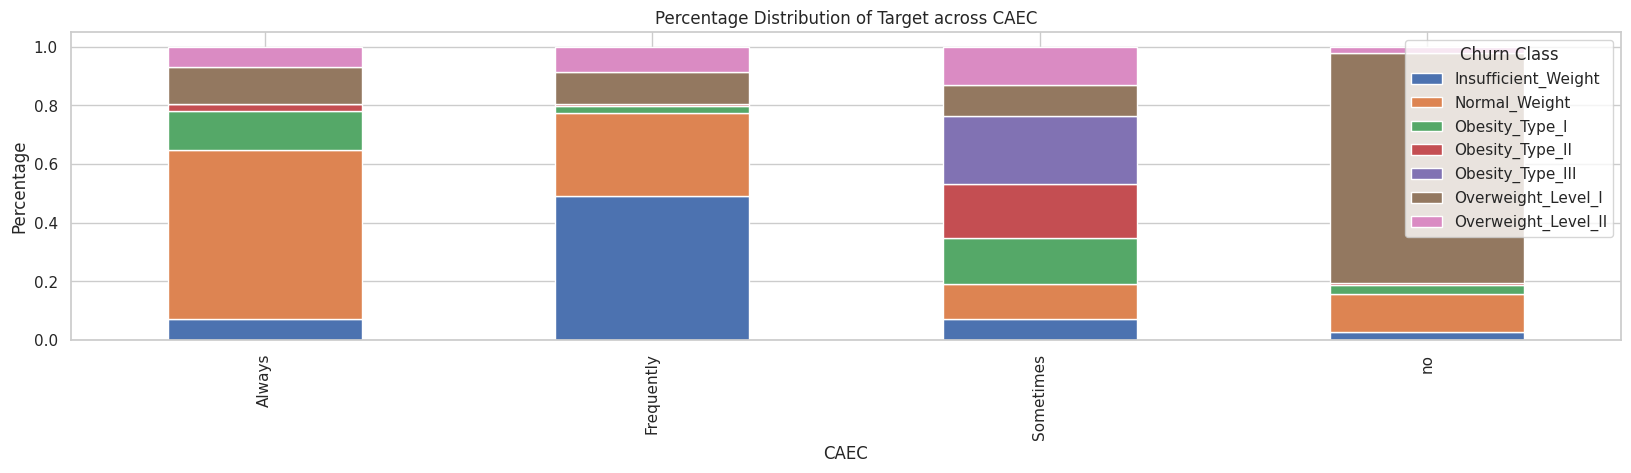

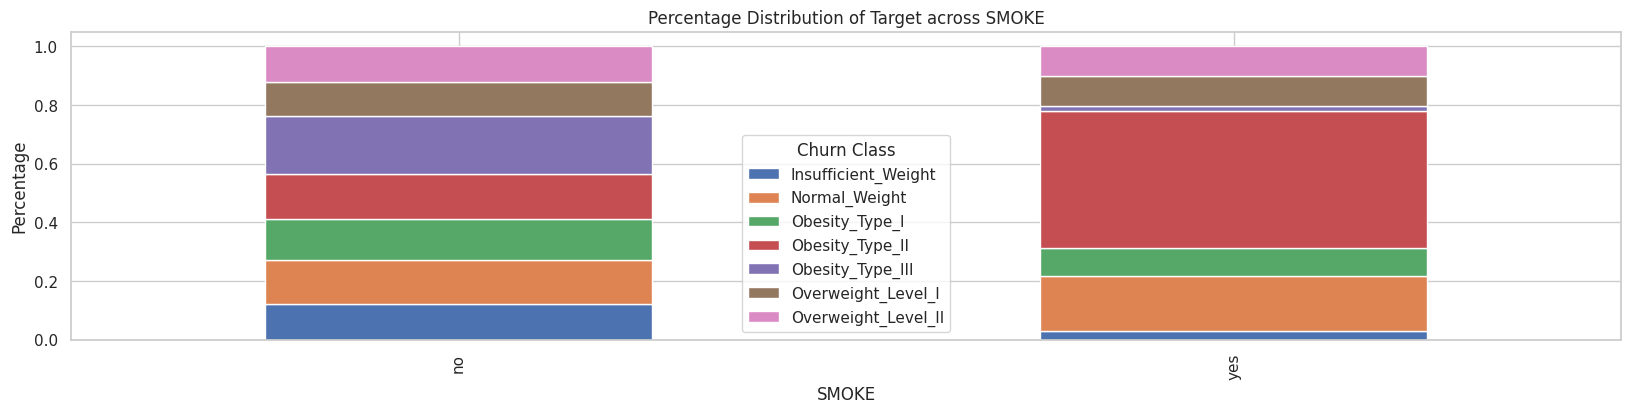

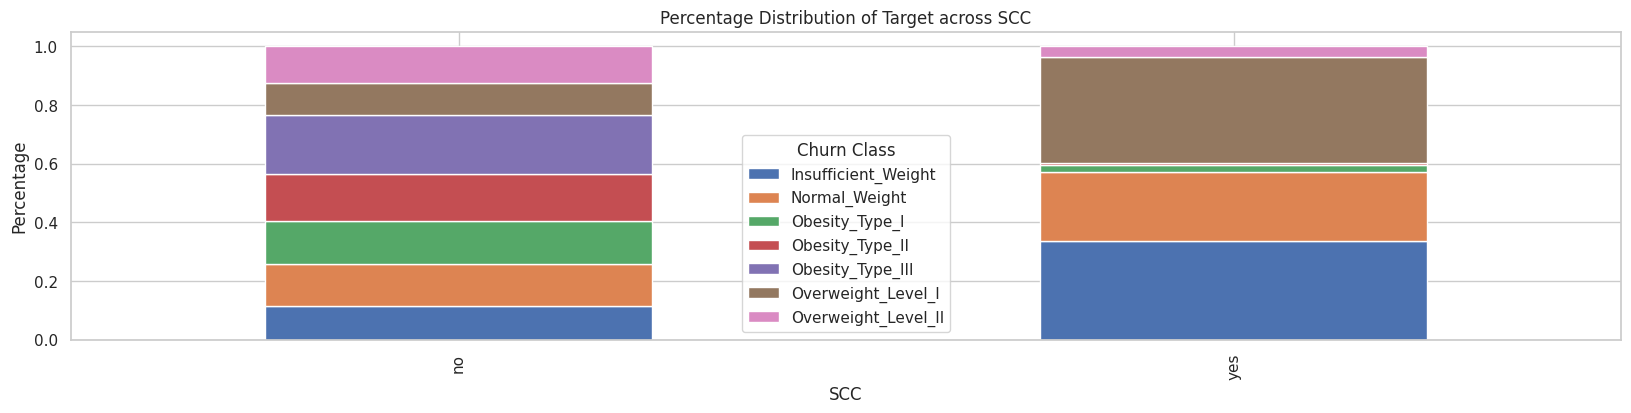

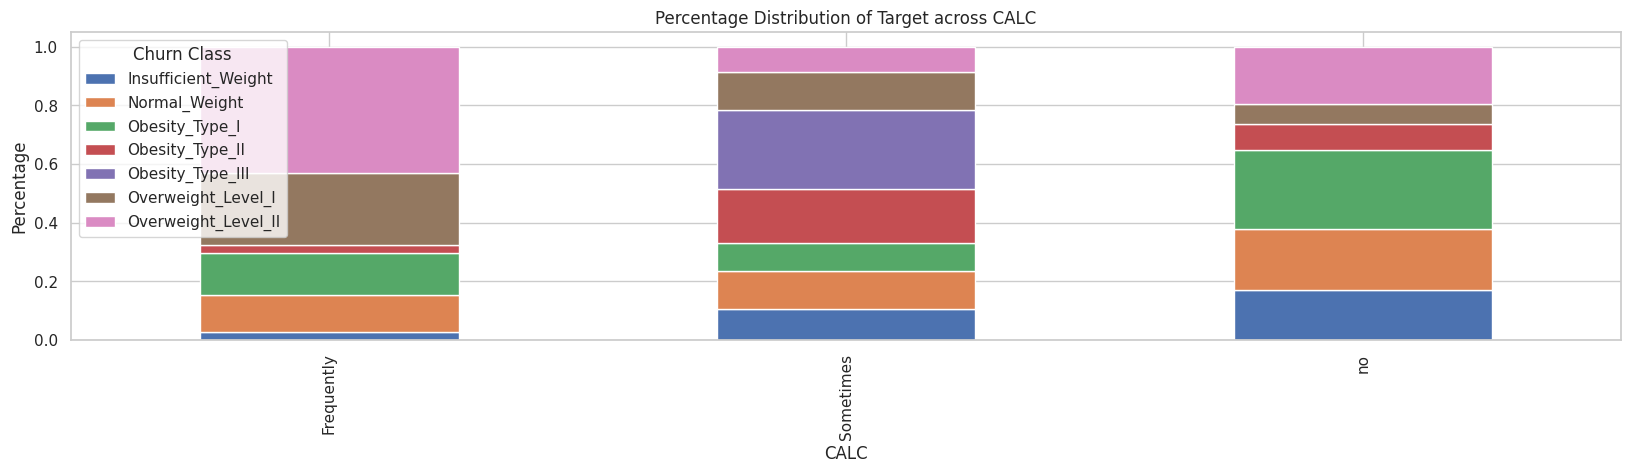

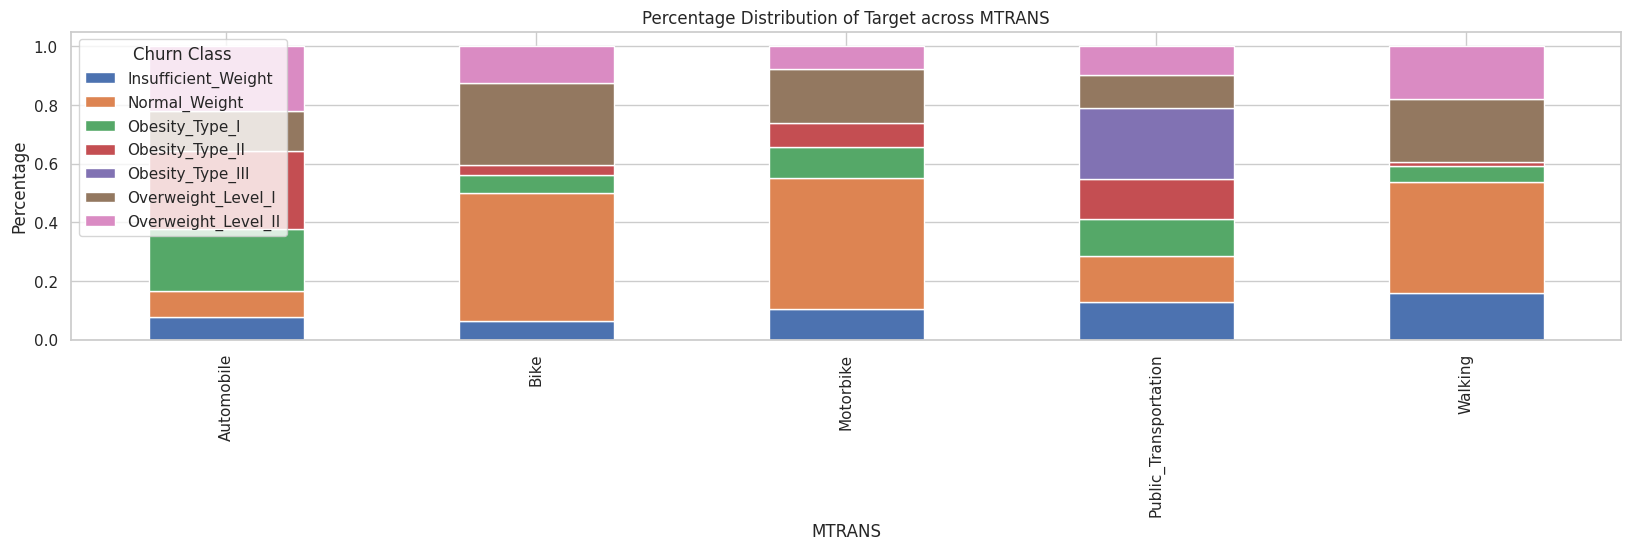

In [7]:
# Select categorical columns with fewer than 100 unique values
cat_cols = [f for f in test.columns if (df[f].dtype != 'O' and df[f].nunique() < 100) or (df[f].dtype == 'O' and f not in ['Exited'] and df[f].nunique() < 100)]

# Iterate through each categorical column and create a bar plot
for col in cat_cols:
    # Create a contingency table
    contingency_table = pd.crosstab(df[col], df['NObeyesdad'], normalize='index')
    
    # Set style and plot the bar chart
    sns.set(style="whitegrid")
    contingency_table.plot(kind="bar", stacked=True, figsize=(20, 4))
    
    # Set plot labels and title
    plt.title(f"Percentage Distribution of Target across {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.legend(title="Churn Class")
    
    # Show the plot
    plt.show()

## 1.3 Feature Engineering

In [8]:
# Split Our Data to Target and Feautres
target = 'NObeyesdad'
y = df.pop(target)
X = df.copy()

In [9]:
def Prep(df):
    # Calculate BMI
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

    # Convert Age to categorical age groups
    bins = [0, 18, 30, 50, 100]
    labels = ['Child', 'Young Adult', 'Adult', 'Elderly']
    df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

    # Interaction between Weight and Height
    df['Weight_Height_Interaction'] = df['Weight'] * df['Height']

    # Combine frequency of consumption variables
    df['Total_Consumption'] = df['FCVC'] + df['NCP'] + df['FAF'] + df['TUE']

    # Physical Activity Level
    df['Physical_Activity_Level'] = df['FAF'] * (24 - df['TUE'])

    # Composite Risk Score (example)
    df['Risk_Score'] = 0
    df.loc[df['family_history_with_overweight'] == 'yes', 'Risk_Score'] += 1
    df.loc[df['SMOKE'] == 'yes', 'Risk_Score'] += 1
    df.loc[df['Physical_Activity_Level'] < 20, 'Risk_Score'] += 1

    # One-hot encoding for categorical variables
    df = pd.get_dummies(df, columns=['Gender', 'CAEC', 'MTRANS'])

    

    # Create one-hot encoder object
    onehot_encoder = OneHotEncoder(drop='first', sparse=False)

    # Convert object columns to numerical using one-hot encoding
    object_cols = df.select_dtypes(include='object').columns
    onehot_encoded = onehot_encoder.fit_transform(df[object_cols])
    onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(object_cols))
    df = pd.concat([df.drop(object_cols, axis=1), onehot_df], axis=1)
    return df

In [10]:
X = Prep(X)
test = Prep(test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
X.drop(columns='id',inplace=True)

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   Age                                 20758 non-null  float64 
 1   Height                              20758 non-null  float64 
 2   Weight                              20758 non-null  float64 
 3   FCVC                                20758 non-null  float64 
 4   NCP                                 20758 non-null  float64 
 5   CH2O                                20758 non-null  float64 
 6   FAF                                 20758 non-null  float64 
 7   TUE                                 20758 non-null  float64 
 8   BMI                                 20758 non-null  float64 
 9   Age_Group                           20758 non-null  category
 10  Weight_Height_Interaction           20758 non-null  float64 
 11  Total_Consumption           

# 2.Model Building

## 2.1 Split

In [13]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=3)
# Identify categorical features for CatBoost
cat_features = np.where(X.dtypes != np.float64)[0]

## 2.2 Training

In [14]:
params = {'learning_rate': 0.13762007048684638, 'depth': 5, 
          'l2_leaf_reg': 5.285199432056192, 'bagging_temperature': 0.6029582154263095,
         'random_seed': 42,
          'eval_metric':'AUC',
        'verbose': False,
         'iterations':4000}

In [15]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_test, y_test,cat_features=cat_features)
    
clf = CatBoostClassifier(
**params)
clf.fit(train_pool, eval_set=val_pool,verbose=300)

0:	test: 0.9432086	best: 0.9432086 (0)	total: 176ms	remaining: 11m 44s
300:	test: 0.9927852	best: 0.9927852 (300)	total: 28s	remaining: 5m 43s
600:	test: 0.9932434	best: 0.9932434 (600)	total: 55.1s	remaining: 5m 11s
900:	test: 0.9933309	best: 0.9933561 (862)	total: 1m 22s	remaining: 4m 45s
1200:	test: 0.9933797	best: 0.9934080 (1135)	total: 1m 51s	remaining: 4m 19s
1500:	test: 0.9933531	best: 0.9934080 (1135)	total: 2m 20s	remaining: 3m 53s
1800:	test: 0.9933006	best: 0.9934080 (1135)	total: 2m 49s	remaining: 3m 26s
2100:	test: 0.9932111	best: 0.9934080 (1135)	total: 3m 17s	remaining: 2m 58s
2400:	test: 0.9931146	best: 0.9934080 (1135)	total: 3m 46s	remaining: 2m 30s
2700:	test: 0.9930635	best: 0.9934080 (1135)	total: 4m 15s	remaining: 2m 2s
3000:	test: 0.9929929	best: 0.9934080 (1135)	total: 4m 44s	remaining: 1m 34s
3300:	test: 0.9929547	best: 0.9934080 (1135)	total: 5m 13s	remaining: 1m 6s
3600:	test: 0.9928941	best: 0.9934080 (1135)	total: 5m 42s	remaining: 37.9s
3900:	test: 0.9928

## 2.3 Evaluation

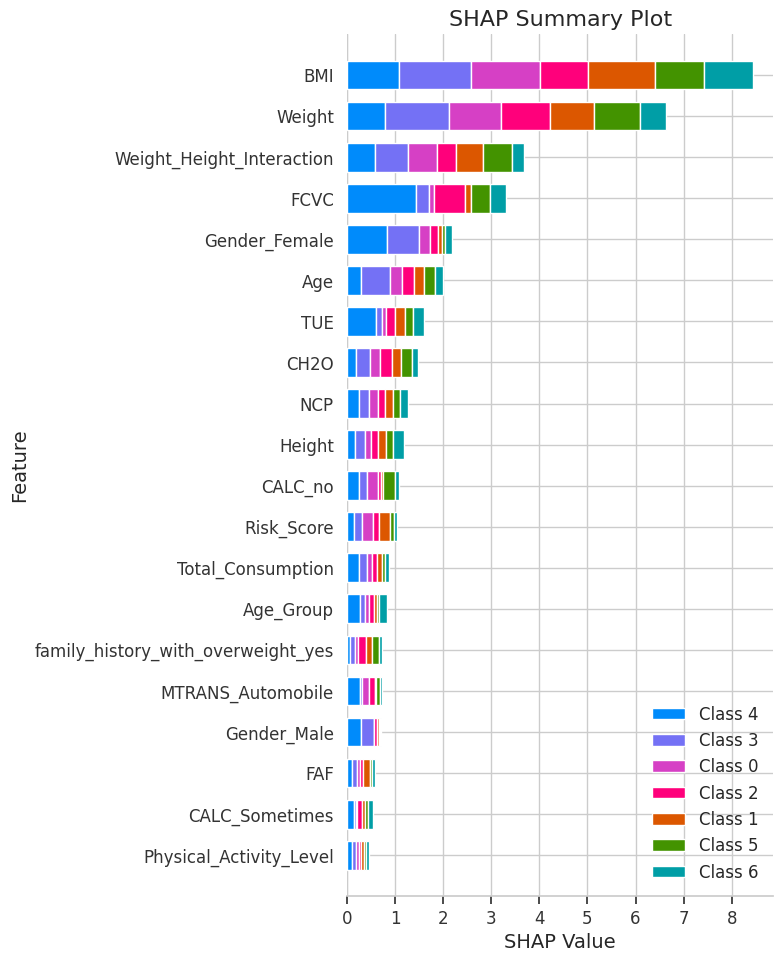

In [16]:
import shap

# Initialize SHAP explainer using the trained CatBoost classifier
explainer = shap.TreeExplainer(clf)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(train_pool)

# Create a SHAP summary plot with a bar plot type
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)

# Customize the plot aesthetics
plt.title("SHAP Summary Plot", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("SHAP Value", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Show the plot
plt.show()

# 3.Submission

In [17]:
df_sub = test[['id']]
test.drop(columns='id',inplace=True)
y_pred = clf.predict(test)
y_pred = np.squeeze(y_pred)
df_sub['NObeyesdad'] = y_pred
# Display the first few rows of the submission DataFrame
df_sub.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [18]:
# Sample submission (to get right format)
sub=pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

# Add predictions
df_sub.to_csv("submission.csv",index=False)